In [ ]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".13"

In [2]:
import pandas as pd
from brain import BrainModel
from submodels import factories
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from random import shuffle

from lib.score import (
    fate_corr, score_both_size_norm, shrink_and_align_stats, score_stats_norm
)
from lib.preprocess import *
from lib.callback import (
    cell_number_callback, progenitor_number_callback, neuron_number_callback,
    TargetPopulation, TagNumberCallback, TypeNumberCallback,
)
from lib.sde.grn.grn5 import GRNMain5 as GRNMain
from lib.sde.mutate import mutate_grn5 as mutate_grn

from lib.ga.utils import weighted_selection_one, normalize_fitness_values
from lib.utils import pick_best, pick_last
from jf.utils.export import Exporter
from jf.autocompute.jf import O, L
from itertools import product
import jf.models.stringmodel as sm
from lib.analyser import show_curve, show_curve_progenitor
from jf.models.stringmodel import read_model
from lib.utils import normalize_time, align_time

In [3]:
_count = -1
def provide_id():
    global _count
    _count += 1
    return _count

In [4]:
REF = O(
    stats=pd.read_csv("reference/ref_tristate2.csv"),  # ref is a mean
)
SM_GEN = read_model("generation")

In [5]:
def individual_generator(id_=-1, cb_init=None):
    sol = Solution(GRNMain(5, 0, 1, generate_funcs=cb_init), id_=id_)
    sol.grn.set_mutable()
    sol.grn.genes[0].init = 1
    for gene in sol.grn.genes:
        gene.noise = max(1, gene.noise)
    sol.grn.compile()
    return sol

In [6]:
class Solution:
    def __init__(self, grn, id_=0, parent=-1):
        self.id = id_
        self.grn = grn
        self.parent = parent
        self.fit = -1
        self.stats = None
        
    def copy(self, id_=0):
        return Solution(self.grn.copy(), id_=id_, parent=self.id)
        
    def mutate(self):
        mutate_grn(self.grn)

In [7]:
def score_bb_size(bb, ref, *args, **kwargs):
    stats = bb.stats.copy()
    stats, ref_stats = align_time(stats, ref.stats)
    stats_p, ref_p = normalize_time(stats, ref_stats, "progenitor_pop_size", "progenitor_pop_size")
    stats_infra, ref_n = normalize_time(stats, ref_stats, "infra_pop_size", "neuron_pop_size",
                                    "progenitor_pop_size", "progenitor_pop_size")
    stats_supra, _ = normalize_time(stats, ref_stats, "supra_pop_size", "neuron_pop_size",
                                    "progenitor_pop_size", "progenitor_pop_size")
    last_time_stats, last_time_ref = max(stats.time), max(ref_stats.time)
    time_switch = 64.0
    
    ref_p = ref_p.set_index("time")
    ref_n = ref_n.set_index("time")
    stats_p = stats_p.set_index("time")
    stats_infra = stats_infra.set_index("time")
    stats_supra = stats_supra.set_index("time")
    
    prog_early = stats_p.loc[min(last_time_stats, time_switch)]["progenitor_pop_size"]
    neuron_infra_early = stats_infra.loc[min(last_time_stats, time_switch)]["infra_pop_size"]
    neuron_supra_early = stats_supra.loc[min(last_time_stats, time_switch)]["supra_pop_size"]
    
    prog_late = stats_p.loc[last_time_stats]["progenitor_pop_size"]
    neuron_infra_late = stats_infra.loc[last_time_stats]["infra_pop_size"]
    neuron_supra_late = stats_supra.loc[last_time_stats]["supra_pop_size"]
    
    ref_prog_early = ref_p.loc[time_switch]["progenitor_pop_size"]
    ref_neuron_infra_early = ref_n.loc[time_switch]["neuron_pop_size"]
    ref_neuron_supra_early = 0.0
    
    ref_prog_late = ref_p.loc[last_time_ref]["progenitor_pop_size"]
    ref_neuron_infra_late = ref_neuron_infra_early
    ref_neuron_supra_late = ref_n.loc[last_time_ref]["neuron_pop_size"] - ref_neuron_infra_late
    
    delta_late = (abs(prog_late - ref_prog_late) + abs(neuron_infra_late - ref_neuron_infra_late)
                  + abs(neuron_supra_late - ref_neuron_supra_late))
    delta_early = (abs(prog_early - ref_prog_early) + abs(neuron_infra_early - ref_neuron_infra_early)
                  + abs(neuron_supra_early - ref_neuron_supra_early))

    return 1 / max(1, 100 - 1 * delta_late - 0.5 * delta_early)

In [8]:
def setup_tag(cp):
    indexes = list(cp.base_population.keys())
    shuffle(indexes)
    splits = np.array_split(indexes, 3)
    for i, ls in enumerate(splits):
        for idx in ls:
            cp.base_population[idx].tag["subbrain"] = i

In [9]:
def get_bb(prun, grn):
    from submodels.grn_bi_v1 import GRNCell
    ccls = factories["grn_bi1"](grn=grn)
    callbacks = dict(
        progenitor_pop_size=progenitor_number_callback,
        whole_pop_size=cell_number_callback,
        neuron_pop_size=neuron_number_callback,
        infra_pop_size=TypeNumberCallback(GRNCell.PostMitoticInfra, TargetPopulation.whole),
        supra_pop_size=TypeNumberCallback(GRNCell.PostMitoticSupra, TargetPopulation.whole),
    )
    bb = BrainModel(time_step=0.25, verbose=False, start_population=prun.size, max_pop_size=5e2,
            cell_cls=ccls, end_time=prun.end_time, start_time=56, silent=True, opti=True,
              run_tissue=True, monitor_callbacks=callbacks, tag_func=setup_tag)
    return bb

In [10]:
def run_grn(prun, grn):
    get_bb(prun, grn)
    bb.run()
    return bb

In [11]:
def fitness_multistep(prun, grn, steps):
    total_fitness = 0
    stop = False
    previous_time = None
    bb = get_bb(prun, grn)
    # first step
    for step in steps:
        if not bb.run_until(step.end_time):
            stop = True
        
        score_step = step.score_func(bb, prun.ref, max_step=step.end_time, min_step=step.start_time)
        fitness_step = 1.0 / score_step
        fitness_step = min(fitness_step, step.max_fitness)
        total_fitness += fitness_step
        if fitness_step < step.min_fitness or stop:
            return total_fitness, bb.stats
        else:
            previous_time = step.end_time
            step.passed()
        
    return total_fitness, bb.stats

In [12]:
def do_init(prun):
    return individual_generator(provide_id(), prun.cb_init)

def do_fitness(prun, sol):
    fitness, stats = fitness_multistep(prun, sol.grn, prun.steps)
    return fitness, stats

def do_selection(prun, pop_fit, pop):
    if len(pop) < prun.min_pop:
        return individual_generator(provide_id(), prun.cb_init)
    
    pop_fit = normalize_fitness_values(pop_fit)
    
    return weighted_selection_one(pop, pop_fit, lambda x: individual_generator(x, prun.cb_init), new_fitness=10., id_=provide_id())[0]

def do_mutation(prun, sol):
    sol.mutate()
    return sol

In [13]:
class ObjectiveStep(O):
    start_time = 0
    end_time = 0
    max_fitness = 1e9
    min_fitness = 1
    name = ""
    _passed = False
    
    def reset(self):
        self._passed = False
    
    def passed(self):
        if self._passed:
            return
        print(f"Step {self.name} passed !")
        self._passed = True
    
example_steps = [
    # ObjectiveStep(name="1", start_time=50, end_time=53, score_func=score_bb_size, min_fitness=0.2),
    # ObjectiveStep(name="2", start_time=53, end_time=56, score_func=score_bb_size, min_fitness=0.2),
    ObjectiveStep(name="3", start_time=56, end_time=86, score_func=score_bb_size, min_fitness=0.2),
]

class ParamRun(O):
    pop_size = 50
    batch_size = 50
    n_gen = 50
    current_gen = 0
    end_time = 86
    ref = REF
    min_pop = 50
    max_pop = 50

def get_prun(size=7, exponent=1):
    prun = ParamRun()
    prun.cb_init = dict()
    prun.size = size
    prun.exponent = exponent
    prun.steps = example_steps
    return prun

In [14]:
def pick_last_exported(exporter):
    generations = list(filter(SM_GEN.match, exporter.list()))
    if len(generations) == 0:
        return None, 0
    
    last = max(generations, key=lambda x: int(SM_GEN.extract(x).get("generation")))
    b_gen = int(SM_GEN.extract(last).get("generation")) + 1
    exporter.print(f"Found generation {b_gen - 1}", "reload")
    pop = exporter.load(last)
    return pop, b_gen

In [15]:
def main(prun):
    prun.history = dict()
    exporter = Exporter(name=prun.name, copy_stdout=True)
    definition = """
    
    """
    exporter.print(definition, slot="definition")
    best = 0
    
    # setup
    pop, batch_gen = pick_last_exported(exporter)
    
    if pop is None:
        sol = do_init(prun)
        pop = [sol]
        batch_gen = 0
    else:
        sol = pop[-1]
        
    for i in range(batch_gen * prun.batch_size,
                   prun.n_gen * prun.batch_size):
        fit, stats = do_fitness(prun, sol)
        sol.fit, sol.stats = fit, stats
        
        if i % 100 == 0:
            exporter.print(f"Step {i}")
        if fit > best:
            exporter.print(f"++ Best {fit} for generation {i}")
            best = fit
            
        monitor = sol
        prun.history[i] = monitor
        # exporter(monitor, f"generation_g{generation}")
        
        sub_pop = pop[-prun.max_pop:]
        sol = do_selection(prun, [s.fit for s in sub_pop], sub_pop)
            
        sol = do_mutation(prun, sol)
        pop.append(sol)
        
        if (i + 1) % prun.batch_size == 0:
            print("Saving ...")
            batch_gen = (i + 1) // 100
            exporter(pop[-prun.max_pop:], SM_GEN.fill(generation=batch_gen))
        
    return best

In [16]:
callback_init = dict(
    init=lambda: np.random.beta(1.5, 3) * 3,
    b=lambda: np.random.beta(1.5, 3) * 5,
    expr=lambda: 1,
    deg=lambda: 0.1,
    noise=lambda: np.random.beta(1.5, 3) * 1,
    asym=lambda: 5,
)

In [17]:
prun = get_prun()
prun.cb_init = callback_init
prun.name = "check_simple_obj_r22"
res = main(prun)

Exporting at output/check_simple_obj_r22
[definition] 
    
    
[out] Step 0
[out] ++ Best 63.70630490036891 for generation 0
[out] ++ Best 71.38963125311975 for generation 1
[out] ++ Best 71.64473329393608 for generation 3
[out] ++ Best 71.96105982454833 for generation 5
Step 3 passed !
[out] ++ Best 72.25697819189526 for generation 13
[out] ++ Best 72.34881492658914 for generation 18
[out] ++ Best 72.82840676332384 for generation 47
Saving ...
[out] ++ Best 72.93044757965036 for generation 58
Saving ...
[out] Step 100
[out] ++ Best 73.12432513067077 for generation 133
[out] ++ Best 73.18554962046669 for generation 147
Saving ...
[out] ++ Best 73.3590190082218 for generation 155
[out] ++ Best 73.54269247760955 for generation 157
[out] ++ Best 73.62432513067077 for generation 158
[out] ++ Best 73.78759043679322 for generation 176
[out] ++ Best 73.79779451842586 for generation 183
[out] ++ Best 74.5838559207771 for generation 194
Saving ...
[out] Step 200
[out] ++ Best 74.8491620432260

In [18]:
exp = Exporter(name=prun.name)

Exporting at output/check_simple_obj_r22


In [19]:
sm = read_model("generation")

In [20]:
res = pick_best(exp.load(pick_last(exp)))

In [21]:
for i in range(5):
    print(fitness_multistep(prun, res.grn, prun.steps))

(92.94027872605325,        infra_pop_size  neuron_pop_size  progenitor_pop_size  supra_pop_size  \
56.00             0.0              0.0                 49.0             0.0   
56.25            10.0             14.0                 42.0             4.0   
56.50            10.0             14.0                 43.0             4.0   
56.75            10.0             14.0                 44.0             4.0   
57.00            10.0             15.0                 45.0             5.0   
...               ...              ...                  ...             ...   
85.00           147.0           1286.0                158.0          1139.0   
85.25           148.0           1300.0                163.0          1152.0   
85.50           150.0           1314.0                164.0          1164.0   
85.75           151.0           1328.0                158.0          1177.0   
86.00           153.0           1335.0                166.0          1182.0   

        time  whole_pop_size  


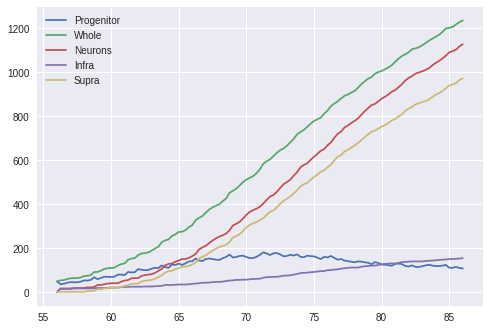

In [22]:
def quick_show(stats):
    plt.plot(stats.time, stats.progenitor_pop_size, label="Progenitor")
    plt.plot(stats.time, stats.whole_pop_size, label="Whole")
    plt.plot(stats.time, stats.neuron_pop_size, label="Neurons")
    plt.plot(stats.time, stats.infra_pop_size, label="Infra")
    plt.plot(stats.time, stats.supra_pop_size, label="Supra")
    plt.legend()
    
quick_show(res.stats)

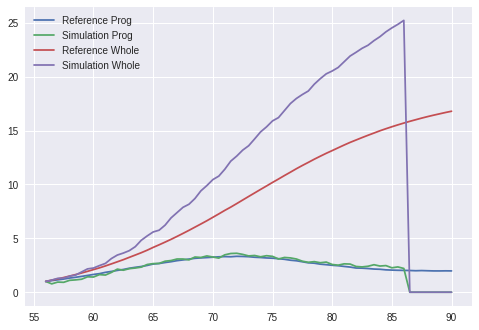

In [23]:
show_curve(res.stats, REF.stats)

In [24]:
for g in sorted(filter(sm.match, exp.list()), key=lambda x: int(sm.extract(x)["generation"])):
    gen = exp.load(g)
    res = pick_best(gen)
    print()
    print(f"======= GENERATION {g} =======")
    print(res.grn)


======= GENERATION generation_g0 =======
>> G_0: init: 1.00; noise: 1.00; b: 1.11; m: 2.40; expr: 1.00; deg: 0.10; theta: 9.34; asym: 5.00; tree : 2
>> G_1: init: 0.13; noise: 1.00; b: 3.13; m: 4.19; expr: 1.00; deg: 0.10; theta: 1.75; asym: 5.00; tree : ((1 AND 5) OR 0)
>> G_2: init: 0.66; noise: 1.00; b: 3.28; m: 9.21; expr: 1.00; deg: 0.10; theta: 6.40; asym: 5.00; tree : (-4 OR -5)
>> G_3: init: 1.19; noise: 1.00; b: 0.90; m: 4.43; expr: 1.00; deg: 0.10; theta: 9.11; asym: 5.00; tree : (3 OR (0 OR -4))
>> G_4: init: 0.84; noise: 1.00; b: 0.97; m: 5.54; expr: 1.00; deg: 0.10; theta: 9.04; asym: 5.00; tree : -5

======= GENERATION generation_g1 =======
>> G_0: init: 1.00; noise: 1.00; b: 1.11; m: 2.40; expr: 1.13; deg: 0.10; theta: 9.34; asym: 5.00; tree : 2
>> G_1: init: 0.13; noise: 1.00; b: 3.13; m: 4.19; expr: 1.00; deg: 0.10; theta: 1.40; asym: 5.00; tree : ((1 AND 5) OR 0)
>> G_2: init: 0.66; noise: 1.00; b: 3.28; m: 10.09; expr: 1.00; deg: 0.10; theta: 6.40; asym: 5.00; tree 